In [82]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [85]:
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

B1 = data + 0 *np.sin(2 * np.pi * 6.4 * t) + 50 * signal.square(2 * np.pi * 2* t)
B2 = data + 0 *np.sin(2 * np.pi * 6.4 * t) + 10* signal.square(2 * np.pi * 2 * t)
B3 = data + 0 *np.sin(2 * np.pi * 6.4 * t) + 100* signal.square(2 * np.pi * 2 * t)
B = np.vstack((B1,B2, B3))



In [86]:
B.shape

(3, 5000)

#### Create Transform Object and Analysis Filters

In [87]:
fb = DyadicFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=num_samples, real=True, s_max = 4, dj = 1/20)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
)

#### Transform


In [88]:
def WAICUP(w1, w2):
    D = w2 - w1  # shape (J, T), complex

    # 1) correlations (eqs 6–7), using conjugate inner products
    C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
    C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

    # 2) gain estimate K̂ per scale (eq 8)
    K_hat = C2 / C1                          # shape (J,)
    # (optionally force to real if you know K is real:)
    K_hat = K_hat

    # 3) residuals (eq 9)
    A = (w1-w2) / (K_hat[:,None]-1)  # shape (J, T), complex

    # 4) ambient‑field estimate X(s,τ) (eq 10)
    X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 
    return X, A

w1 = transform.forward(B[0],)
w2 = transform.forward(B[1],)
w3 = transform.forward(B[2],)

X1, A1 = WAICUP(w1, w2)
X2, A2 = WAICUP(w1, w3)
X3, A3 = WAICUP(w2, w3)

abs_A1 = np.abs(A1)  # shape (J, T)
abs_A2 = np.abs(A2)  # shape (J, T)
abs_A3 = np.abs(A3)  # shape (J, T)

# Stack the absolute values along a new axis
abs_A_stack = np.stack([abs_A1, abs_A2, abs_A3], axis=0)  # shape (3, J, T)

# Find the indices of the maximum absolute A values
max_indices = np.argmin(abs_A_stack, axis=0)  # shape (J, T)

# Initialize X_result with the same shape as X1, X2, X3
X_result = np.zeros_like(X1, dtype=X1.dtype)

# Use advanced indexing to select the corresponding X values
# Create a meshgrid of indices for J and T
j_indices, t_indices = np.indices(max_indices.shape)

# Select X values based on max_indices
X_result[j_indices, t_indices] = np.where(
    max_indices == 0, X1[j_indices, t_indices],
    np.where(max_indices == 1, X2[j_indices, t_indices], X3[j_indices, t_indices])
)
X_min = np.minimum.reduce([X1, X2, X3])
result = transform.inverse(X_min)


Raw Error:  75.84829170330613
Raw Error:  57.46236411447363
Cleaned Error:  28.616239404333733


C:\Users\Alex\AppData\Local\Temp\ipykernel_5888\727757349.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


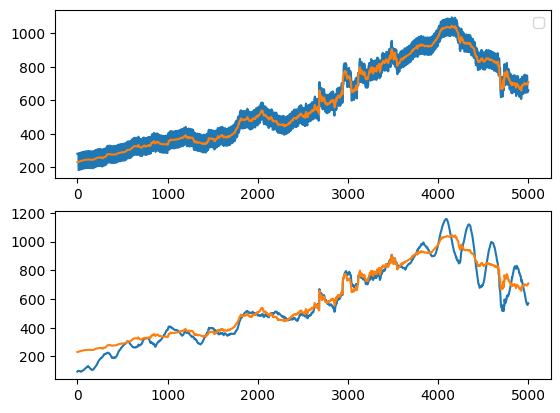

In [89]:
print("Raw Error: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[1000:-1000])**2).mean(axis=0)))

%matplotlib inline
fig, ax = plt.subplots(2,1)

ax[0].legend()
ax[0].plot(B[0])
ax[0].plot(data)
ax[1].plot(result)
ax[1].plot(data)
plt.show()

c:\Users\Alex\Documents\GitHub\InvertibleWavelets\invertiblewavelets\transform.py:281: RuntimeWarning: divide by zero encountered in log
  np.log(power),


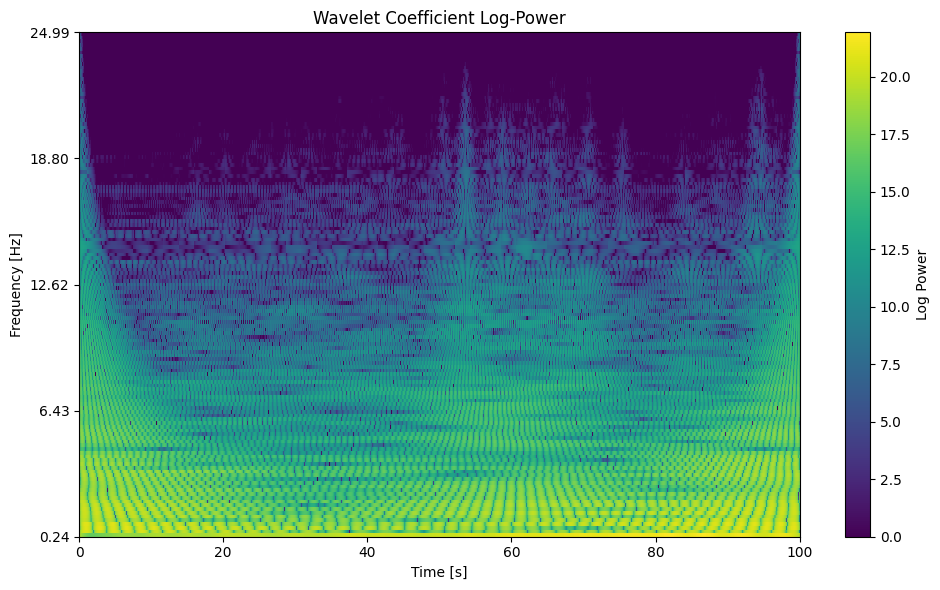

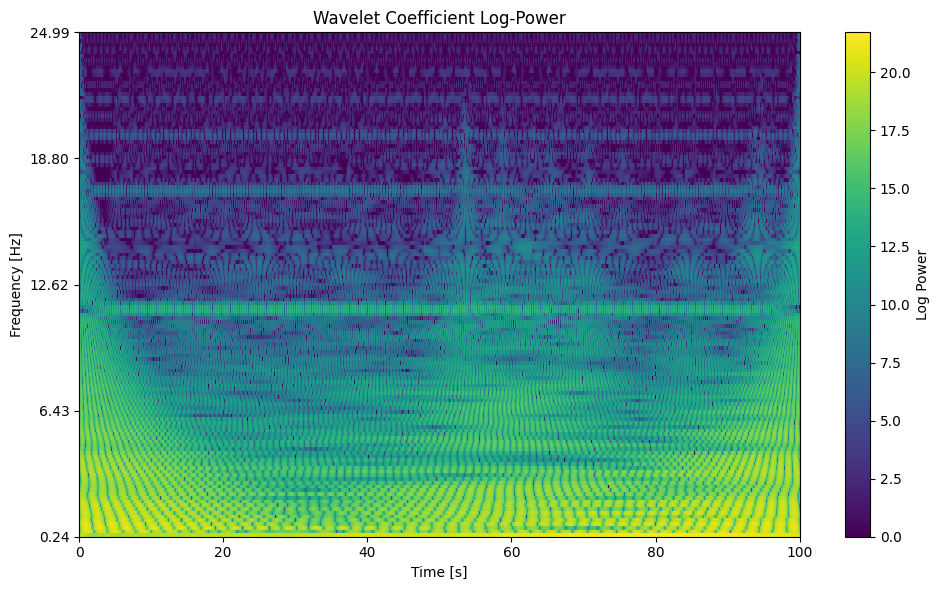

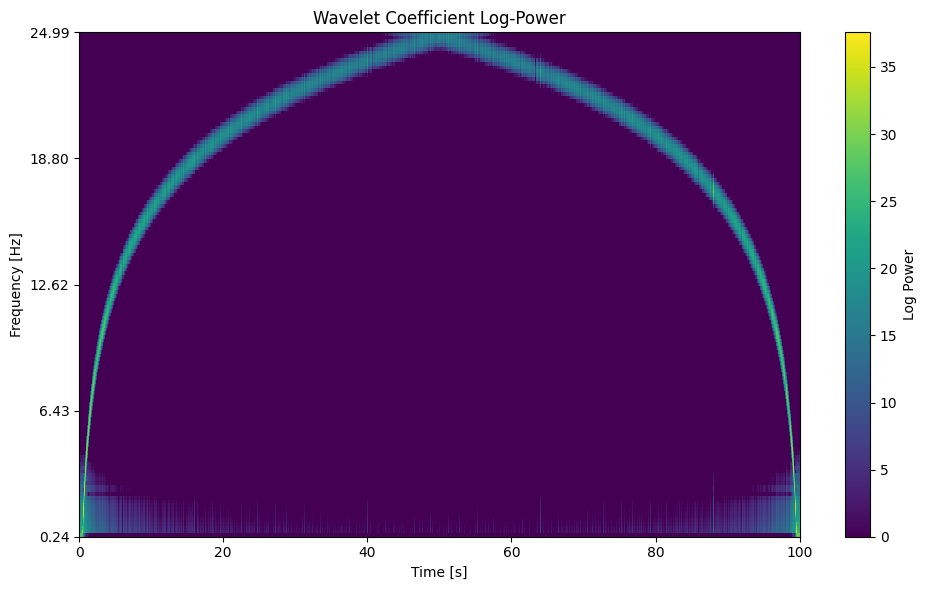

In [90]:
transform.scalogram(X_result, vmin=0, interpolation='none')
transform.scalogram(w2,vmin=0, interpolation='none')
transform.scalogram(np.fft.fft(transform.coefficients, axis=1),vmin=0, interpolation='none')
plt.show()

#### Compare to Normal WAICUP

(630.9531215354667+0j)
60.22913622304047


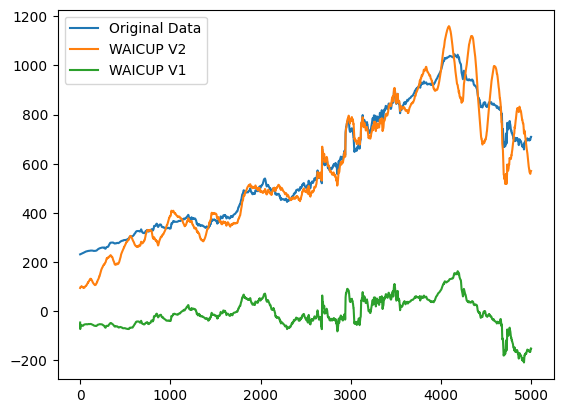

In [70]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend= False
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
print(np.sqrt(((data[100:-100]-result[100:-100])**2).mean(axis=0)))
plt.plot(data, label='Original Data')
plt.plot(result, label='WAICUP V2')
plt.plot(result_baseline, label='WAICUP V1')
plt.legend()
plt.show()

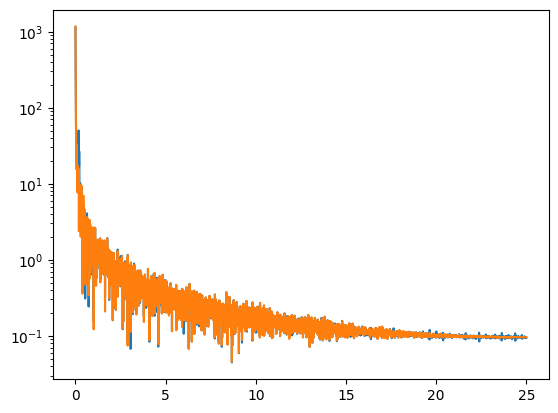

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


In [86]:
fig, ax = plt.subplots(2,1)
i = 0
N = w1.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i+1][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(w1, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')